In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
from collections import deque
import os

In [2]:
def invert(x):
    # inverts ts
    # opposite of differencing a time series
    # x[0] contains the original time series value for integrated series
    y = np.ndarray(len(x))
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = x[i] + y[i-1]
#     print(len(invx) == len(x))
    return y

In [3]:
def generate_arima(n, ar_coeff=[0.6,], ma_coeff=[-0.1,]):
    d=1 # difference set to 1. cannot integrate more than once.(Don't know how to integrate so...)
    #this function appends 1 to ar and ma coeff. negates ar coeff
    #calls arma_generate_sample method.
    ar = np.r_[1, -np.array(ar_coeff)]
    ma = np.r_[1, np.array(ma_coeff)]
    print("generating ARMA(%d,%d)"%(len(ar_coeff), len(ma_coeff)))
    arma = arma_generate_sample(ar, ma, n)
#     return arma
    return invert(arma)

In [4]:
# model = arma_generate_sample(ar=[1,0.5], ma=[1,-0.5], nsample=1000)
# model1 = generate_arima(n=1000,ar_coeff=[0.5, -0.25], ma_coeff=[0.5, -0.3])
model1 = generate_arima(1000, ar_coeff=[0.6,], ma_coeff=[-0.1,])

generating ARMA(1,1)


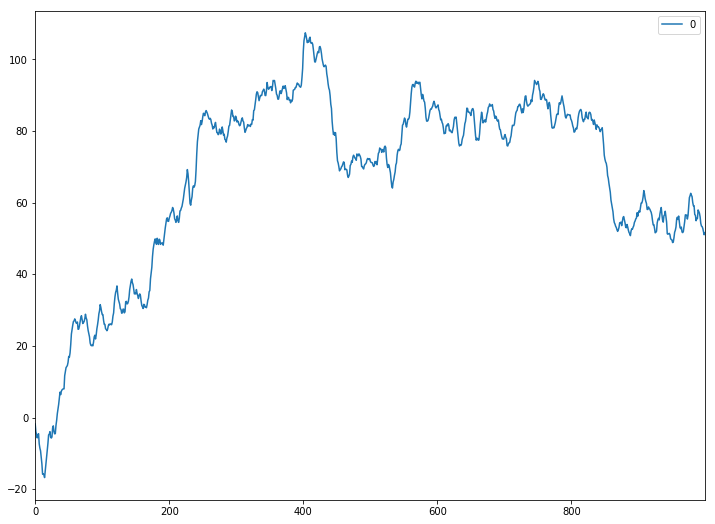

In [5]:
# pd.DataFrame(model).plot(figsize=(12,9))
pd.DataFrame(model1).plot(figsize=(12,9))

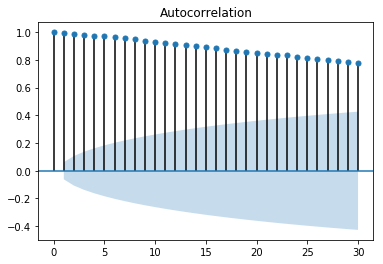

In [6]:
# plot_pacf(model, lags=30)
# plt.show()
plot_acf(model1, lags=30)
plt.show()


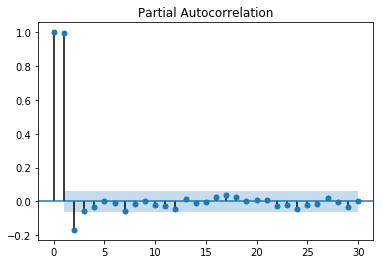

In [7]:
plot_pacf(model1, lags=30)
plt.show()

In [8]:
def test_arma(values, p=1,q=1):
    tmodel = ARIMA(endog=values, order = (p,1, q))
    #We cannot use ARMA(values ) because we need to check order for every q to test.
    mf = tmodel.fit()
    print(mf.summary())
    print("k_ma = ", mf.k_ma)
    print("k_ar = ", mf.k_ar)
    print("coeff = ",mf.params)
    print("Conf Int \n",mf.conf_int())
    return mf

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  999
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1390.645
Method:                       css-mle   S.D. of innovations              0.973
Date:                Wed, 22 May 2019   AIC                           2789.290
Time:                        19:48:03   BIC                           2808.917
Sample:                             1   HQIC                          2796.750
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0514      0.064      0.803      0.422      -0.074       0.177
ar.L1.D.y      0.5448      0.052     10.547      0.000       0.444       0.646
ma.L1.D.y     -0.0515      0.061     -0.841      0.4

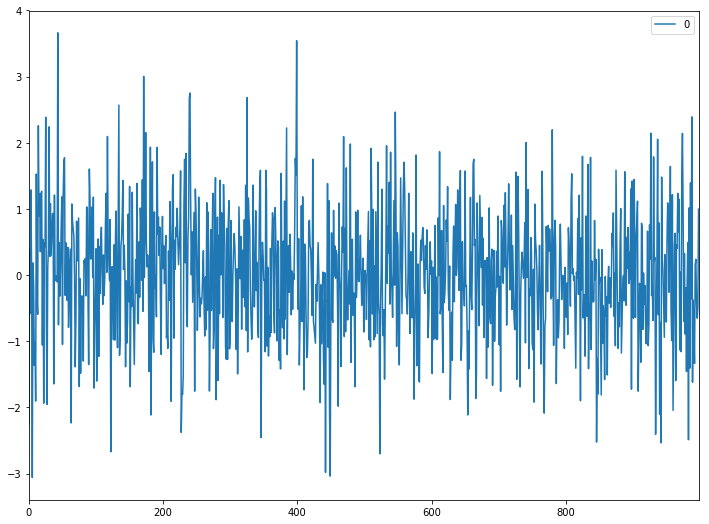

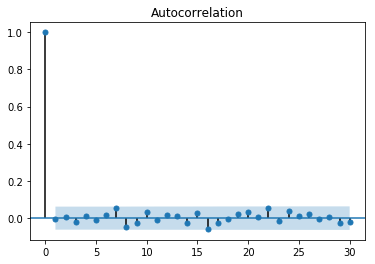

In [9]:
# test_ma_q(model, p=2,q=2)
mf = test_arma(model1, p=1,q=1)
pd.DataFrame(mf.resid).plot(figsize=(12,9))
plot_acf(mf.resid, lags=30)
plt.show()
#acf of residual series must be white noise

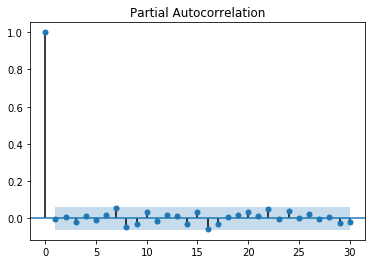

In [10]:
plot_pacf(mf.resid, lags=30)
plt.show()

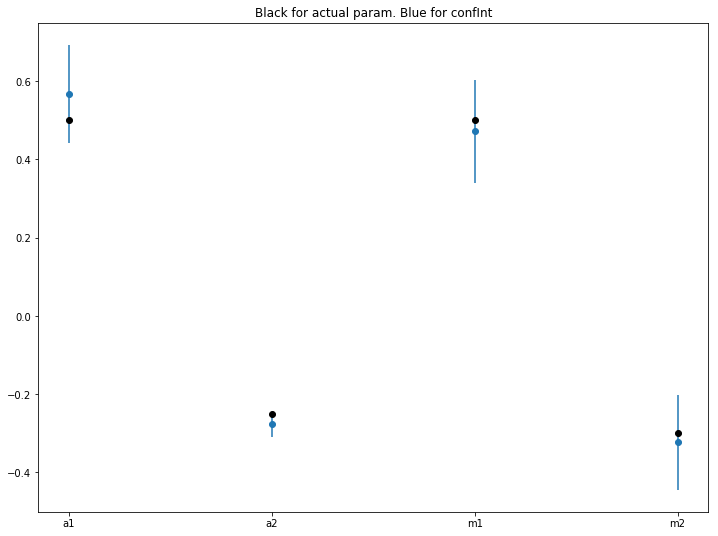

In [11]:
x = ['a1','a2','m1','m2']
y = [0.5665, -0.2774, 0.4712, -0.3226]
yerr = [0.126, 0.033, 0.131, 0.121]
plt.figure(figsize=(12,9))
plt.errorbar(x, y,yerr=yerr ,fmt='o')
plt.plot(x, [0.5, -0.25, 0.5, -0.3], 'ko')
#[np.array(yerr)*(-1.96), np.array(yerr)*1.96] ,
plt.title("Black for actual param. Blue for confInt")
plt.show()

In [12]:
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import display
def determine_arma_order(values):
    plt.plot(values)
    finalmodel = None
    finalorder = (0,0)
    finalaic = np.inf
    for p,q in product(list(range(4)), list(range(4))):
        print("testing for (%d, %d)"%(p,q))
        try:
#             test = ARMA(endog=values, order=(p,q))
            test = ARIMA(endog=values, order=(p,0,q))
            tf = test.fit()
            aic = tf.aic
            if aic < finalaic:
                finalaic = aic
                finalorder = (p,1, q)
                finalmodel = test
        except:
            pass
            print("Cannot fit for (%d, %d)"%(p,q))
    print("final order, AIC: ", finalorder, finalaic)
    finalmodel = ARMA(endog=values, order=finalorder)
    resid = finalmodel.fit(ic='aic').resid
    #Ljung-box test to determine whether ARMA(p,q) is a good fit
    plot_acf(resid, lags=30)
    lbxresid = acorr_ljungbox(resid, lags=20)
    df = pd.DataFrame()
    df['test-Stat Q value'] = lbxresid[0]
    df['p-value'] = lbxresid[1]
    df['reject'] = df['p-value']<=0.05
    display(df)

generating ARMA(2,2)
testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
Cannot fit for (0, 2)
testing for (0, 3)
Cannot fit for (0, 3)
testing for (1, 0)
testing for (1, 1)
Cannot fit for (1, 1)
testing for (1, 2)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:961: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:964: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/scipy/signal/signaltools.py:970: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

Cannot fit for (1, 2)
testing for (1, 3)
testing for (2, 0)
Cannot fit for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
Cannot fit for (3, 0)
testing for (3, 1)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


testing for (3, 2)
testing for (3, 3)
final order, AIC:  (3, 1, 2) 2855.3496441757957


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


test-Stat Q value   p-value  reject
0            0.013058  0.909022   False
1            0.623245  0.732258   False
2           10.333076  0.015937    True
3           12.283297  0.015364    True
4           17.625918  0.003454    True
5           17.682776  0.007076    True
6           17.950509  0.012195    True
7           18.267917  0.019305    True
8           20.392366  0.015639    True
9           20.562983  0.024356    True
10          21.646163  0.027262    True
11          22.367343  0.033603    True
12          24.053981  0.030637    True
13          25.567053  0.029365    True
14          25.621993  0.042189    True
15          25.811478  0.056739   False
16          25.864991  0.076956   False
17          25.991654  0.099949   False
18          27.114320  0.102018   False
19          27.120170  0.131917   False

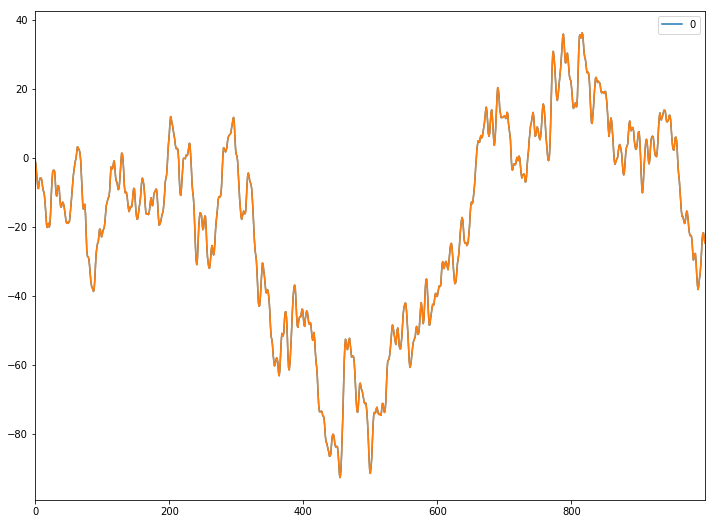

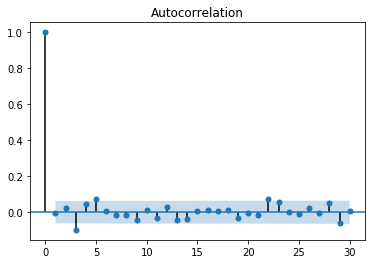

In [13]:
values = generate_arima(n=1000, ar_coeff=[.75, -.25], ma_coeff=[.65, .35])
pd.DataFrame(values).plot(figsize=(12,9))
# values = np.diff(np.log(pd.read_csv('../data/INFY.csv')['Close']))
# values = generate_arima(1000, ar_coeff=[0.6,0.1], ma_coeff=[-0.1, -0.2])
determine_arma_order(values)

In [14]:
test = ARIMA(endog=values, order=(2,1,2))
tf = test.fit()

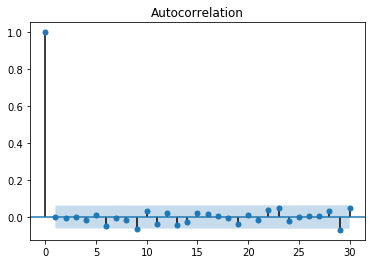

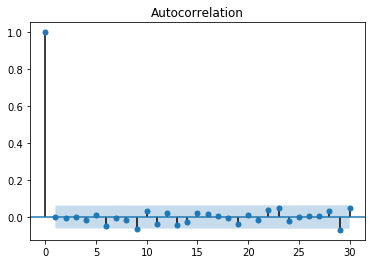

In [15]:
plot_acf(tf.resid, lags=30)

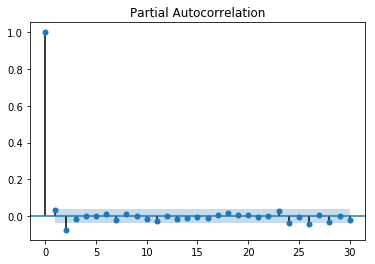

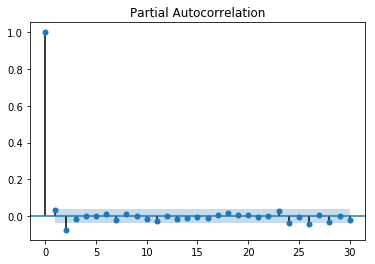

In [29]:
infy = pd.read_csv('../data/INFY.csv', index_col='Date')

cl = pd.DataFrame(infy['Close'])
cl['logClose'] = np.log(infy['Close'])
cl['diffLogClose'] = cl['logClose'] - cl['logClose'].shift(1)
cl = cl.dropna()
plot_pacf(cl['diffLogClose'].values, lags=30)
plt.show()
plot_pacf(cl['diffLogClose'].values, lags=30)
plt.show()

testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
Cannot fit for (0, 2)
testing for (0, 3)
Cannot fit for (0, 3)
testing for (1, 0)
testing for (1, 1)
testing for (1, 2)
testing for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)
final order, AIC:  (3, 1, 0) 18833.026647073035


test-Stat Q value   p-value  reject
0            0.001219  0.972150   False
1            0.023071  0.988531   False
2            0.187515  0.979579   False
3            0.191942  0.995679   False
4            0.295706  0.997723   False
5            0.690157  0.994701   False
6            2.356086  0.937539   False
7            2.450844  0.963984   False
8            2.611897  0.977721   False
9            4.079879  0.943672   False
10           4.440527  0.955218   False
11           4.678467  0.967866   False
12           4.749592  0.980300   False
13           4.779465  0.988651   False
14           4.790449  0.993757   False
15           4.807560  0.996630   False
16           4.826101  0.998221   False
17           5.140149  0.998625   False
18           5.277665  0.999159   False
19           6.203665  0.998593   False

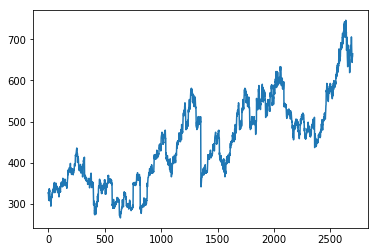

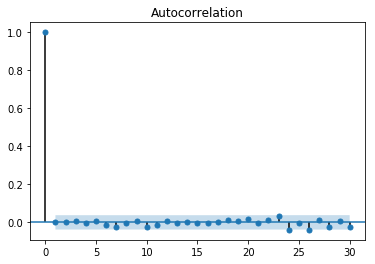

In [17]:
determine_arma_order(infy['Close'].values)

testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
testing for (0, 3)
testing for (1, 0)
testing for (1, 1)
testing for (1, 2)
testing for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


final order, AIC:  (2, 1, 0) -14017.438034593331


test-Stat Q value   p-value  reject
0            0.000028  0.995804   False
1            0.001758  0.999121   False
2            0.019953  0.999255   False
3            0.130732  0.997954   False
4            0.130901  0.999685   False
5            0.431469  0.998575   False
6            1.370758  0.986450   False
7            1.575485  0.991382   False
8            1.578051  0.996525   False
9            2.359025  0.992775   False
10           4.832106  0.939024   False
11           4.832911  0.963328   False
12           5.439213  0.964210   False
13           5.709568  0.973289   False
14           5.730870  0.983922   False
15           5.986877  0.988237   False
16           6.126424  0.992295   False
17           7.304814  0.987294   False
18           7.457050  0.991349   False
19           7.524137  0.994577   False

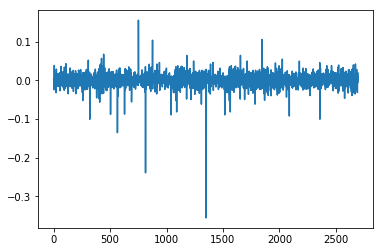

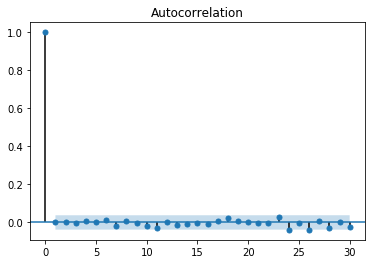

In [18]:
determine_arma_order(cl['diffLogClose'].values)